In [1]:
from bmtool.analysis.lfp import load_ecp_to_xarray, cwt_spectrogram_xarray, fit_fooof, get_windowed_data, ecp_to_lfp, plot_spectrogram
import numpy as np
import matplotlib.pyplot as plt


ecp = load_ecp_to_xarray('/home/gjgpb9/cortex_modeling/V1_Layer5/Run-Storage/final_result_2/block1/long/ecp.h5')
lfp = ecp_to_lfp(ecp)

In [ ]:
downsample_freq = 200 # if you want to further down sample
tseg = 0.5  # time segment length for PSD
use_cwt = True
axis = lfp.dims.index('time')

lfp_sxx = cwt_spectrogram_xarray(lfp, lfp.fs, axis=axis, downsample_fs = downsample_freq,
                                        channel_coords={'channel_id': ecp.channel_id}, freq_range=(1 / tseg, np.inf))

### whole simulation spectrogram 

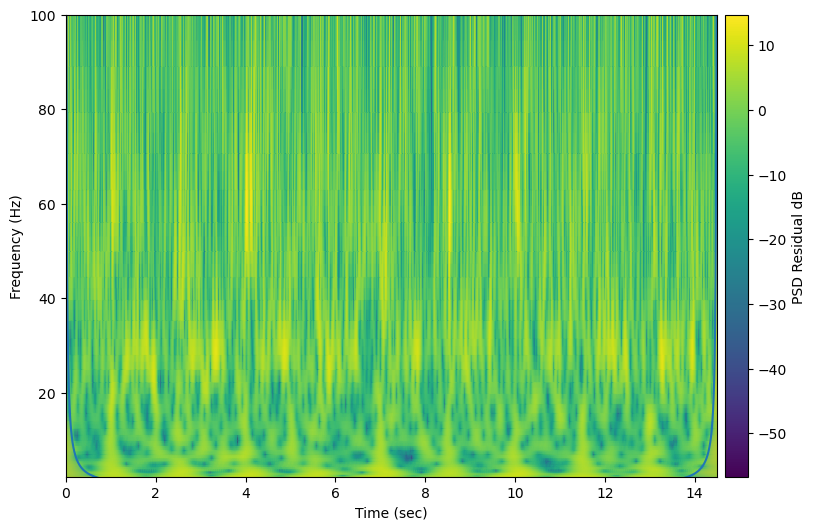

In [3]:
fooof_params = dict(aperiodic_mode='fixed', freq_range=(1,100), peak_width_limits=100.)
plt_range = [2., 100.]
clr_freq_range = None
log_power = 'dB'

fig, ax = plt.subplots(1,1,figsize=(10,6))
sxx = lfp_sxx.sel(channel_id=0)
sxx_tot = sxx.PSD.mean(dim='time')
fooof_results, _ = fit_fooof(sxx_tot.frequency.values, sxx_tot.values, **fooof_params)
_ = plot_spectrogram(sxx, remove_aperiodic=fooof_results, log_power=log_power,
                        plt_range=plt_range, clr_freq_range=clr_freq_range, pad=0.01, ax=ax)

### To make it a bit more clear we can avg the trials of our stimulus together 

/home/gjgpb9/miniconda3/envs/bmtk/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


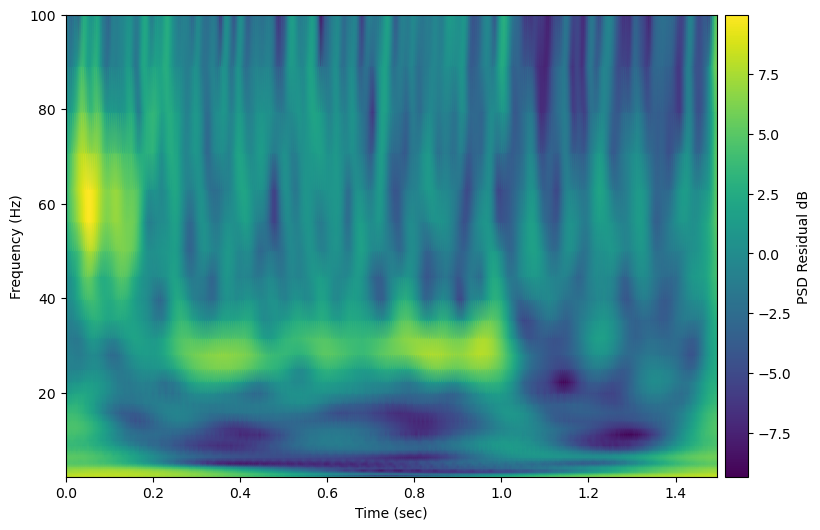

In [4]:
# in this example there are 9 pulses given for 1 second with a 500ms break before the next pulse. The pulse starts 1 second into the simulation 
on_time = 1 # how long in seconds is our stimulus
off_time = 0.5 # how long is the break between stim is 
t_start = 1 # when starts in sec
stimulus_count = 9

times_to_avg = []
for i in range(stimulus_count):
    end_time = t_start+on_time+off_time
    times_to_avg.append([t_start,end_time])
    t_start = end_time 

# make list into np array 
times_to_avg = np.array(times_to_avg)

_, _, lfp_sxx_avg = get_windowed_data(lfp_sxx.PSD, times_to_avg, {0: np.arange(times_to_avg.shape[0])})
lfp_sxx_avg = lfp_sxx_avg[0].mean_.sel(unique_cycle=0).to_dataset(name='PSD')

fig, ax = plt.subplots(1,1,figsize=(10,6))
sxx = lfp_sxx_avg.sel(channel_id=0)
sxx_tot = sxx.PSD.mean(dim='time')
fooof_results, _ = fit_fooof(sxx_tot.frequency.values, sxx_tot.values, **fooof_params)
_ = plot_spectrogram(sxx, remove_aperiodic=fooof_results, log_power=log_power,
                        plt_range=plt_range, clr_freq_range=clr_freq_range, pad=0.01, ax=ax)
